In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import xarray as xr
import xesmf as xe
import os
import sys
from pathlib import Path
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt


HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))

from dsrnngan import data, read_config
from dsrnngan.noise import NoiseGenerator

2022-11-10 12:09:43.944637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-10 12:09:44.317129: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-10 12:09:45.241759: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /system/slurm/22.05.2/lib:/system/pmix-v3/lib:/user/work/uz22147/miniconda3/lib:/user/work/uz22147/miniconda3/lib/:/user/work/uz22147/miniconda3/lib/
2022-11-10 12:09:45.242000: W tensorflow/stream_execut

In [3]:
import yaml
from glob import glob
from dsrnngan.evaluation import setup_inputs

model_folder='/user/home/uz22147/logs/cgan'
model_number= [12800]
val_years=2020

model_weights_root = os.path.join(model_folder, "models")
config_path = os.path.join(model_folder, 'setup_params.yaml')
df_dict = read_config.read_config()['DOWNSCALING']

most_recent_model = sorted(glob(os.path.join(model_weights_root, '*.h5')))[-1]

In [4]:
most_recent_model = sorted(glob(os.path.join(model_weights_root, '*.h5')))[-1]

In [7]:
with open(config_path, 'r') as f:
    try:
        setup_params = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(exc)

mode = setup_params["GENERAL"]["mode"]
arch = setup_params["MODEL"]["architecture"]
padding = setup_params["MODEL"]["padding"]
batch_size = 1  # setup_params["TRAIN"]["batch_size"]
fcst_data_source=setup_params['DATA']['fcst_data_source']
obs_data_source=setup_params['DATA']['obs_data_source']
input_channels = setup_params['DATA']['input_channels']
constant_fields = setup_params['DATA']['constant_fields']
fcst_image_width = setup_params['DATA']['fcst_image_width']
output_image_width = setup_params['DATA']['output_image_width']
constants_image_width = setup_params['DATA']['constants_width']
problem_type = setup_params["GENERAL"]["problem_type"]
downsample = setup_params['GENERAL']['downsample']
filters_gen = setup_params["GENERATOR"]["filters_gen"]
noise_channels = setup_params["GENERATOR"]["noise_channels"]
latent_variables = setup_params["GENERATOR"]["latent_variables"]
filters_disc = setup_params["DISCRIMINATOR"]["filters_disc"]
num_batches = setup_params["EVAL"]["num_batches"]
add_noise = setup_params["EVAL"]["add_postprocessing_noise"]

print('setting up inputs')
gen, batch_gen_valid = setup_inputs(mode=mode,
                                arch=arch,
                                fcst_data_source=fcst_data_source,
                                obs_data_source=obs_data_source,
                                load_constants=False,
                                downscaling_steps=df_dict["steps"],
                                val_years=val_years,
                                downsample=downsample,
                                input_channels=input_channels,
                                constant_fields=constant_fields,
                                filters_gen=filters_gen,
                                filters_disc=filters_disc,
                                noise_channels=noise_channels,
                                latent_variables=latent_variables,
                                padding=padding)

print('loading weights')
gen.load_weights(most_recent_model)

setting up inputs
generator_input shape: (None, None, None, 5)
constants_input shape: (None, None, None, 1)
upscaled constants shape: (None, None, None, 64)
noise_input shape: (None, None, None, 4)
Shape after first concatenate: (None, None, None, 73)
End of first residual block
Shape after first residual block: (None, None, None, 64)
Shape after upsampling step 1: (None, None, None, 64)
Shape after residual block: (None, None, None, 64)
Shape after second concatenate: (None, None, None, 65)
Shape after third residual block: (None, None, None, 64)
Output shape: (None, None, None, 1)
generator_input shape: (None, None, None, 5)
constants_input shape: (None, None, None, 1)
generator_output shape: (None, None, None, 1)
upscaled constants shape: (None, None, None, 256)
Shape after lo-res concatenate: (None, None, None, 261)
Shape after hi-res concatenate: (None, None, None, 2)
Shape of lo-res input after residual block: (None, None, None, 512)
Shape of hi_res_input after upsampling step 1:

In [8]:
denormalise_data = True
rank_samples = 1

batch_gen_iter = iter(batch_gen_valid)

inputs, outputs = next(batch_gen_iter)
cond = inputs['lo_res_inputs']
const = inputs['hi_res_inputs']
truth = outputs['output']
truth = np.expand_dims(np.array(truth), axis=-1)

if denormalise_data:
    truth = data.denormalise(truth)

noise_shape = np.array(cond)[0, ..., 0].shape + (noise_channels,)
noise_gen = NoiseGenerator(noise_shape, batch_size=batch_size)

for ii in range(rank_samples):
    img_gen = gen.predict([cond, const, noise_gen()])

1/1 [==============================] - 2s 2s/step


In [9]:
from matplotlib import colorbar, colors, gridspec

def plot_img(img, value_range=(np.log10(0.1), np.log10(100)), extent=None):
    plt.imshow(img,
               interpolation='nearest',
               norm=colors.Normalize(*value_range),
               origin='lower',
               extent=extent)
    plt.gca().tick_params(left=False, bottom=False,
                          labelleft=False, labelbottom=False)

Text(0.5, 1.0, 'ERA5')

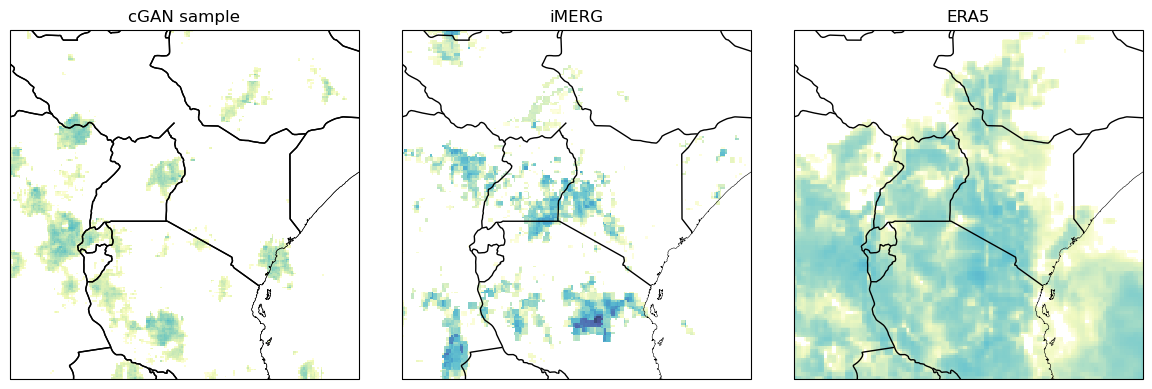

In [10]:
import os
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors, gridspec

from dsrnngan import data
from dsrnngan.noise import NoiseGenerator
from dsrnngan.rapsd import plot_spectrum1d, rapsd
from dsrnngan.thresholded_ranks import findthresh
from dsrnngan.plots import plot_img_log_coastlines

palette="YlGnBu"
linewidth = 0.4
cmap = ListedColormap(sns.color_palette(palette, 256))
cmap.set_under('white')
extent = [min(data.DEFAULT_LONGITUDE_RANGE), max(data.DEFAULT_LONGITUDE_RANGE), min(data.DEFAULT_LATITUDE_RANGE), max(data.DEFAULT_LATITUDE_RANGE)]
alpha = 0.8
spacing = 10
units = "Rain rate [mm h$^{-1}$]"
cb_tick_loc = np.array([0.1, 0.5, 1, 2, 5, 15, 30, 50])
cb_tick_labels = [0.1, 0.5, 1, 2, 5, 15, 30, 50]
value_range_precip=(0.1, 30)

num_rows = 1
num_cols = 3

figsize = (num_cols*5, num_rows*5)
plt.figure(figsize=figsize)

gs = gridspec.GridSpec(spacing*num_rows+1, spacing*num_cols, wspace=0.5, hspace=0.5)

i = 0
k = 0

plt.subplot(gs[(spacing*i):(spacing+spacing*i), (spacing*k):(spacing+spacing*k)],
                        projection=ccrs.PlateCarree())
ax = plt.gca()
ax.coastlines(resolution='10m', color='black', linewidth=linewidth)
plot_img_log_coastlines(img_gen[0, :,:,0],
                                        value_range_precip=value_range_precip,
                                        cmap=cmap,
                                        extent=extent,
                                        alpha=alpha)
ax.add_feature(cfeature.BORDERS)
# ax.add_feature(cfeature.LAKES)
ax.set_title('cGAN sample')

i = 0
k = 0

plt.subplot(gs[(spacing*i):(spacing+spacing*i), (spacing*k):(spacing+spacing*k)],
                        projection=ccrs.PlateCarree())
ax = plt.gca()
ax.coastlines(resolution='10m', color='black', linewidth=linewidth)
plot_img_log_coastlines(img_gen[0, :,:,0],
                                        value_range_precip=value_range_precip,
                                        cmap=cmap,
                                        extent=extent,
                                        alpha=alpha)
ax.add_feature(cfeature.BORDERS)
# ax.add_feature(cfeature.LAKES)
ax.set_title('cGAN sample')

##  iMERG
k = 1

plt.subplot(gs[(spacing*i):(spacing+spacing*i), (spacing*k):(spacing+spacing*k)],
                        projection=ccrs.PlateCarree())
ax = plt.gca()
ax.add_feature(cfeature.BORDERS)
# ax.add_feature(cfeature.LAKES)
ax.coastlines(resolution='10m', color='black', linewidth=linewidth)
plot_img_log_coastlines(truth[0, :,:,0],
                                        value_range_precip=value_range_precip,
                                        cmap=cmap,
                                        extent=extent,
                                        alpha=alpha)

ax.set_title('iMERG')

## ERA5
k = 2

plt.subplot(gs[(spacing*i):(spacing+spacing*i), (spacing*k):(spacing+spacing*k)],
                        projection=ccrs.PlateCarree())
ax = plt.gca()
ax.coastlines(resolution='10m', color='black', linewidth=linewidth)
plot_img_log_coastlines(cond[0, :,:,0],
                                        value_range_precip=value_range_precip,
                                        cmap=cmap,
                                        extent=extent,
                                        alpha=alpha)
ax.add_feature(cfeature.BORDERS)
# ax.add_feature(cfeature.LAKES)
ax.set_title('ERA5')

In [11]:
truth.shape

(1, 200, 200, 1)

In [12]:
cond.shape

(1, 200, 200, 5)

In [16]:
img_gen.shape

(1, 200, 200, 1)